<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 5.  Соревнование Kaggle "Catch Me If You Can"

На этой неделе мы вспомним про концепцию стохастического градиентного спуска и опробуем классификатор Scikit-learn SGDClassifier, который работает намного быстрее на больших выборках, чем алгоритмы, которые мы тестировали на 4 неделе. Также мы познакомимся с данными [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации пользователей и сделаем в нем первые посылки. По итогам этой недели дополнительные баллы получат те, кто попадет в топ-30 публичного лидерборда соревнования.

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Стохатический градиентный спуск](https://www.coursera.org/learn/supervised-learning/lecture/xRY50/stokhastichieskii-ghradiientnyi-spusk)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   
**Также рекомендуется вернуться и просмотреть [задание](https://www.coursera.org/learn/supervised-learning/programming/t2Idc/linieinaia-rieghriessiia-i-stokhastichieskii-ghradiientnyi-spusk) "Линейная регрессия и стохастический градиентный спуск" 1 недели 2 курса специализации.**

### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1pLsegkAICL9PzOLyAeH9DmDOBfktte0l8JW75uWcTng). 

In [1]:
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.5
IPython 7.10.2

numpy 1.17.4
scipy 1.3.1
pandas 0.25.3
matplotlib 3.1.1
statsmodels 0.10.1
sklearn 0.21.3

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit
Git hash   :


In [3]:
import collections
import functools
import itertools
import os
import pickle
import typing
from warnings import filterwarnings

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

%matplotlib inline
pd.set_option('display.max.columns', 25)
filterwarnings('ignore')

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [4]:
PATH_TO_DATA = 'Data/Raw/'
PATH_TO_PICKLED = 'Data/Pickled/'
PATH_TO_MERGED = 'Data/Merged/'
PATH_TO_ANSWERS = 'Answers/'

In [5]:
read_csv = functools.partial(
    pd.read_csv,
    parse_dates=[f'time{i}' for i in range(1, 11)],
    index_col=0
)
train_df = read_csv(
    os.path.join(PATH_TO_MERGED, 'train_sessions.csv')
)
test_df = read_csv(
    os.path.join(PATH_TO_MERGED, 'test_sessions.csv'),
)

In [6]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [7]:
np.array([3, np.nan])

array([ 3., nan])

**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [8]:
train_test_df = pd.concat((train_df, test_df), sort=False)

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null datetime64[ns]
site2     250098 non-null float64
time2     250098 non-null datetime64[ns]
site3     246919 non-null float64
time3     246919 non-null datetime64[ns]
site4     244321 non-null float64
time4     244321 non-null datetime64[ns]
site5     241829 non-null float64
time5     241829 non-null datetime64[ns]
site6     239495 non-null float64
time6     239495 non-null datetime64[ns]
site7     237297 non-null float64
time7     237297 non-null datetime64[ns]
site8     235224 non-null float64
time8     235224 non-null datetime64[ns]
site9     233084 non-null float64
time9     233084 non-null datetime64[ns]
site10    231052 non-null float64
time10    231052 non-null datetime64[ns]
target    253561 non-null int64
dtypes: datetime64[ns](10), float64(9), int64(2)
memory usage: 42.6 MB


In [10]:
train_test_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0.0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,3846.0,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0.0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,39.0,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0.0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,782.0,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0.0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,178.0,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82793,812,2014-10-02 18:20:09,1039.0,2014-10-02 18:20:09,676.0,2014-10-02 18:20:09,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN
82794,300,2014-05-26 14:16:40,302.0,2014-05-26 14:16:41,302.0,2014-05-26 14:16:44,300.0,2014-05-26 14:16:44,300.0,2014-05-26 14:17:19,1222.0,2014-05-26 14:17:19,302.0,2014-05-26 14:17:19,1218.0,2014-05-26 14:17:19,1221.0,2014-05-26 14:17:19,1216.0,2014-05-26 14:17:19,NaN
82795,29,2014-05-02 11:21:56,33.0,2014-05-02 11:21:56,35.0,2014-05-02 11:21:56,22.0,2014-05-02 11:22:03,37.0,2014-05-02 11:22:03,6779.0,2014-05-02 11:22:03,30.0,2014-05-02 11:22:03,21.0,2014-05-02 11:22:04,23.0,2014-05-02 11:22:04,6780.0,2014-05-02 11:22:04,NaN


In [11]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null datetime64[ns]
site2     81308 non-null float64
time2     81308 non-null datetime64[ns]
site3     80075 non-null float64
time3     80075 non-null datetime64[ns]
site4     79182 non-null float64
time4     79182 non-null datetime64[ns]
site5     78341 non-null float64
time5     78341 non-null datetime64[ns]
site6     77566 non-null float64
time6     77566 non-null datetime64[ns]
site7     76840 non-null float64
time7     76840 non-null datetime64[ns]
site8     76151 non-null float64
time8     76151 non-null datetime64[ns]
site9     75484 non-null float64
time9     75484 non-null datetime64[ns]
site10    74806 non-null float64
time10    74806 non-null datetime64[ns]
dtypes: datetime64[ns](10), float64(9), int64(1)
memory usage: 13.3 MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [13]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [14]:
train_test_df_sites = train_test_df[(f'site{i}' for i in range(1, 11))].fillna(0).astype(int)

In [15]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


In [16]:
def build_csr_matrix(session_mtx: typing.Union[typing.Sequence[typing.Sequence[int]], pd.DataFrame]) -> csr_matrix:

    if isinstance(session_mtx, pd.DataFrame):
        session_mtx = session_mtx.values

    site_ID_freqs, session_indexes, site_IDs = zip(
        *(
            (site_ID_freq, session_ind, site_ID - 1) 
            for session_ind, site_ID_freqs in enumerate(map(collections.Counter, session_mtx))
            for site_ID, site_ID_freq in site_ID_freqs.items()
            if site_ID != 0
        )
    )
    return csr_matrix((site_ID_freqs, (session_indexes, site_IDs)))

**Создайте разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее. Используйте объединенную матрицу *train_test_df_sites*, потом разделите обратно на обучающую и тестовую части.**

Обратите внимание на то, что в  сессиях меньше 10 сайтов  у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо будет удалить.

**Выделите в отдельный вектор *y* ответы на обучающей выборке.**

In [17]:
%%time
train_test_sparse = build_csr_matrix(train_test_df_sites)

train_len = len(train_df)
X_train_sparse = train_test_sparse[:train_len]
X_test_sparse = train_test_sparse[train_len:]
y = train_df['target'].values

CPU times: user 5.22 s, sys: 139 ms, total: 5.36 s
Wall time: 4.54 s


**<font color='red'>Вопрос 1. </font> Выведите размерности матриц *X_train_sparse* и *X_test_sparse* – 4 числа на одной строке через пробел: число строк и столбцов матрицы *X_train_sparse*, затем число строк и столбцов матрицы *X_test_sparse*.**

In [18]:
print(
    f'Рамерность X_train_sparse:\t{X_train_sparse.shape}\n'
    f'Рамерность X_test_sparse:\t{X_test_sparse.shape}'
)

Рамерность X_train_sparse:	(253561, 48371)
Рамерность X_test_sparse:	(82797, 48371)


**Сохраним в pickle-файлы объекты *X_train_sparse*, *X_test_sparse* и *y* (последний – в файл *kaggle_data/train_target.pkl*).**

In [19]:
with open(os.path.join(PATH_TO_PICKLED, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl)
with open(os.path.join(PATH_TO_PICKLED, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl)
with open(os.path.join(PATH_TO_PICKLED, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl)

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [20]:
train_share = int(0.7 * X_train_sparse.shape[0])

X_train = X_train_sparse[:train_share]
y_train = y[:train_share]

X_valid = X_train_sparse[train_share:]
y_valid = y[train_share:]

**Создайте объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и параметром *random_state*=17. Остальные параметры оставьте по умолчанию, разве что *n_jobs*=-1 никогда не помешает. Обучите  модель на выборке `(X_train, y_train)`.**

In [21]:
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17)
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

**Сделайте прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*.**

In [22]:
probs = sgd_logit.predict_proba(X_valid)[:, 1]

**<font color='red'>Вопрос 2. </font> Посчитайте ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке. Округлите до 3 знаков после разделителя.**

In [23]:
print(
    f'ROC AUC: {roc_auc_score(y_valid, probs):.3}'
)

ROC AUC: 0.934


**Сделайте прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 70%).**

In [24]:
%%time
sgd_logit.fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)[:, 1]

CPU times: user 1.54 s, sys: 17.6 ms, total: 1.56 s
Wall time: 361 ms


**Запишите ответы в файл и сделайте посылку на Kaggle. Дайте своей команде (из одного человека) на Kaggle говорящее название – по шаблону "[YDF & MIPT] Coursera_Username", чтоб можно было легко идентифицировать Вашу посылку на [лидерборде](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard/public).**

**Результат, который мы только что получили, соответствует бейзлайну "SGDCLassifer" на лидерборде, задача на эту неделю – как минимум его побить.**

In [25]:
def write_to_submission_file(predicted_labels: typing.Sequence[float],
                             out_file: str = os.path.join(PATH_TO_ANSWERS, 'week5.csv'),
                             target_label: str = 'target',
                             index_label: str = 'session_id') -> type(None):
    # save predictions as csv file
    to_save = '\n'.join(
        f'{index},{value}' for (index, value) in enumerate(predicted_labels, 1)
    )
    to_save = f'{index_label},{target_label}\n{to_save}'
    with open(out_file, 'w') as out:
        out.write(to_save)

In [26]:
write_to_submission_file(logit_test_pred_proba)

In [27]:
def generate_timediffs(df: pd.DataFrame) -> pd.DataFrame:
    time_stamps = df[filter(lambda col: col[:4] == 'time', df.columns)]

    diffs = time_stamps.diff(axis=1)
    diffs[time_stamps.isna()] = pd.NaT
    diffs = diffs.iloc[:, 1:]

    return pd.DataFrame(
        index=df.index,
        data=(diffs.values / np.timedelta64(1, 's')),
        columns=(f'timediff{i}' for i in range(1, time_stamps.shape[1])),
    )


def calc_mean_and_std_time_diff(time_diff_df: pd.DataFrame) -> typing.Tuple[pd.Series, pd.Series]:
    return (time_diff_df.mean(1), time_diff_df.std(1))


time_of_day = pd.Series(
    itertools.chain(
        itertools.repeat('night',   6),
        itertools.repeat('morning', 6),
        itertools.repeat('day',     6),
        itertools.repeat('evening', 6)
    ),
    name='Hour'
)
# Map from an hour to the corresponding time of day
# Hour range 0:6 is considered as night, 6:12 as morning, 12:18 as day, 18:0 as evening


def calc_time_of_day(df: pd.DataFrame) -> pd.Series:
    return pd.Series(
        index=df.index,
        data=pd.Categorical(
            time_of_day[df['time1'].dt.hour.values].values,
            ordered=True,
            categories=('night', 'morning', 'day', 'evening')
        )
    )


def calc_num_consec_sites(df: pd.DataFrame) -> pd.Series:
    # Calculates the number of consecutive clicks on links within one site per session
    site_IDs = df[filter(lambda col: col[:4] == 'site', df.columns)]
    return ((site_IDs.diff(axis=1) == 0) & (site_IDs != 0)).sum(1)


def generate_additional_features(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(
        {
            'time_of_day': calc_time_of_day(df)
        }
    )

In [28]:
class MutableInt:
    def __init__(self, value: int):
        self.value = value


session_mtx_generic = typing.Union[typing.Sequence[typing.Sequence[int]], pd.DataFrame]

num_generic = typing.Union[int, float]
csr_matrix_layout_generic = typing.Generator[
    typing.Tuple[num_generic, int, int], None, None
]


def __create_layout_for_session_mtx(session_mtx: session_mtx_generic) -> csr_matrix_layout_generic:

    if isinstance(session_mtx, pd.DataFrame):
        session_mtx = session_mtx.values

    csr_layout_generator = (
        (site_ID_freq, session_ind, site_ID - 1) 
        for session_ind, site_ID_freqs in enumerate(map(collections.Counter, session_mtx))
        for site_ID, site_ID_freq in site_ID_freqs.items()
        if site_ID != 0
    )
    return csr_layout_generator


def __create_layout_for_additional_features(df_additional_features: pd.DataFrame,
                                            col_index_to_start_from: int = 0) -> csr_matrix_layout_generic:

    col_index_to_start_from = MutableInt(col_index_to_start_from)

    def process_cat_feature(feature: pd.Series) -> typing.Generator[typing.Tuple[int, int], None, None]:
        # Converts a categorical feature vector to a sequence of corresponding (value, feature_ind) pairs
        feature = feature.values
        feature_IDs = feature.codes + col_index_to_start_from.value

        col_index_to_start_from.value += len(feature.categories)
        return zip(itertools.repeat(1), feature_IDs)


    def process_numeric_feature(feature: pd.Series) -> typing.Generator[
        typing.Tuple[num_generic, int], None, None
    ]:
        # Converts a numeric feature vector to a sequence of corresponding (value, feature_ind) pairs
        feature_ID = col_index_to_start_from.value
        col_index_to_start_from.value += 1
        return zip(feature.values, itertools.repeat(feature_ID))


    session_index_generator = itertools.cycle(range(len(df_additional_features)))

    value_and_feature_index_generator = itertools.chain(

        itertools.chain.from_iterable(
            process_cat_feature(cat_feature) for col_name, cat_feature
            in df_additional_features.select_dtypes('category').iteritems()
        ),

        itertools.chain.from_iterable(
            process_numeric_feature(num_feature) for col_name, num_feature
            in df_additional_features.select_dtypes(np.number).iteritems()
        )

    )

    return (
        (value, session_index, feature_index) for session_index, (value, feature_index)
        in zip(session_index_generator, value_and_feature_index_generator)
    )


def build_csr_matrix(df: pd.DataFrame) -> csr_matrix:
    site_IDs = df[filter(lambda col: col[:4] == 'site', df.columns)].fillna(0).astype(int)

    values, session_ids, feature_ids = zip(
        *itertools.chain(
            __create_layout_for_session_mtx(site_IDs),
            __create_layout_for_additional_features(
                generate_additional_features(df), site_IDs.values.max()
            )
        )
    )
    return csr_matrix((values, (session_ids, feature_ids)))

In [29]:
%%time
train_test_sparse = build_csr_matrix(train_test_df)

train_len = len(train_df)
X_train_sparse = train_test_sparse[:train_len]
X_test_sparse = train_test_sparse[train_len:]
y = train_df['target'].values

CPU times: user 6.3 s, sys: 290 ms, total: 6.59 s
Wall time: 5.27 s


In [30]:
train_share = int(0.7 * X_train_sparse.shape[0])

X_train = X_train_sparse[:train_share]
y_train = y[:train_share]

X_valid = X_train_sparse[train_share:]
y_valid = y[train_share:]

In [31]:
sgd_logit = SGDClassifier(loss='log', n_jobs=-1, random_state=17)
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=17, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [32]:
probs = sgd_logit.predict_proba(X_valid)[:, 1]
print(
    f'ROC AUC: {roc_auc_score(y_valid, probs):.3}'
)

ROC AUC: 0.963


In [33]:
%%time
sgd_logit.fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)[:, 1]

CPU times: user 1.53 s, sys: 22 ms, total: 1.55 s
Wall time: 379 ms


In [34]:
write_to_submission_file(logit_test_pred_proba)

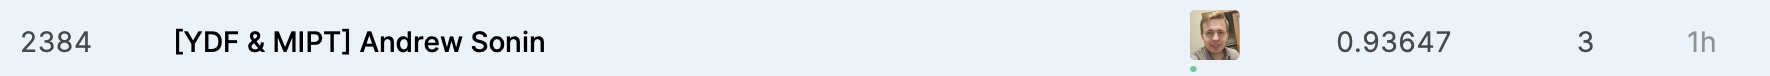
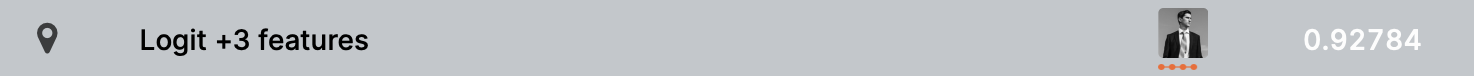

Независимые оценки данного ноутбука на Coursera :з 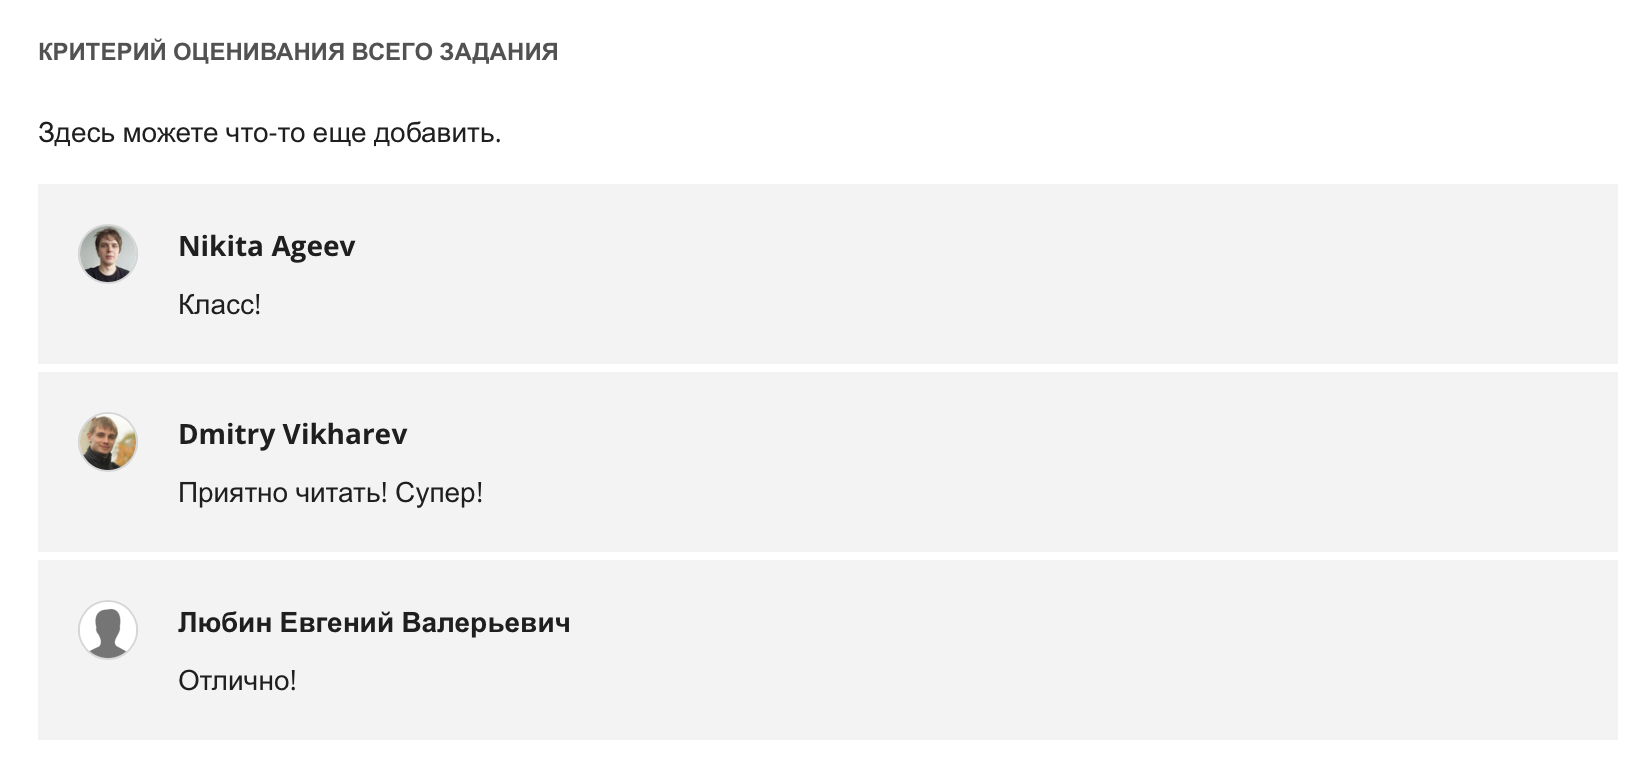

## Критерии оценки работы (только для Peer Review в специализации):
- Правильные ли получились размерности матриц в п. 1? (max. 2 балла)
- Правильным ли получилось значения ROC AUC в п. 2? (max. 4 балла)
- Побит ли бенчмарк "sgd_logit_benchmark.csv" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)
- Побит ли бенчмарк "Logit +3 features" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)

## Пути улучшения
На этой неделе дается много времени на соревнование. Не забывайте вносить хорошие идеи, к которым Вы пришли по ходу соревнования, в описание финального проекта (`html`, `pdf` или `ipynb`). Это только в случае, если вы проходите специализацию.
Что можно попробовать:
 - Использовать ранее построенные признаки для улучшения модели (проверить их можно на меньшей выборке по 150 пользователям, отделив одного из пользователей от остальных – это быстрее)
 - Настроить параметры моделей (например, коэффициенты регуляризации)
 - Если позволяют мощности (или хватает терпения), можно попробовать смешивание (блендинг) ответов бустинга и линейной модели. [Вот](http://mlwave.com/kaggle-ensembling-guide/) один из самых известных тьюториалов по смешиванию ответов алгоритмов, также хороша [статья](https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending) Александра Дьяконова
 - Обратите внимание, что в соревновании также даны исходные данные о посещенных веб-страницах Элис и остальными 1557 пользователями (*train.zip*). По этим данным можно сформировать свою обучающую выборку. 

На 6 неделе мы пройдем большой тьюториал по Vowpal Wabbit и попробуем его в деле, на данных соревнования.